# Mushroom classification
In this notebook I'll be comparing different ML models and its accuracy in simple image classification task. Dataset consist of 9 different classes of mushrooms.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, MobileNet, ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras import regularizers
from PIL import ImageFile
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import utils
import tensorflow as tf
# tf.data.experimental.enable_debug_mode()
# tf.config.run_functions_eagerly(True)
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('ggplot')

2023-04-22 21:34:27.256666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 21:34:27.693484: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Preparing the data

In [2]:
def create_dir(directory):
    if os.path.exists(directory):
        return
    os.mkdir(directory)

def copy_file(src_path, dst_path, file):
    src = os.path.join(src_path, file)
    dst = os.path.join(dst_path, file)
    shutil.copy(src, dst)

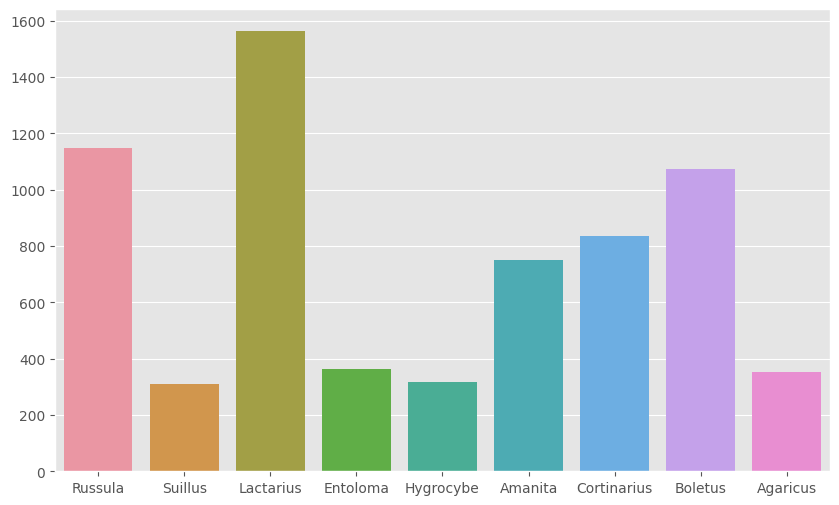

In [3]:
dataset_dir = 'Mushrooms'
classes = os.listdir(dataset_dir)
x = []
y = []
for cl in classes:
    class_length = len(os.listdir(f'{dataset_dir}/{cl}'))
    x.append(cl)
    y.append(class_length)
plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y)
plt.show()

As we can see we need to deal with imbalanced data here. 
<!-- (Therefore let's use class weighting technique.)-->

In [4]:
base_dir = 'mushrooms'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

create_dir(base_dir)
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)

for parent_dir in [train_dir, test_dir, val_dir]:
    for cl in classes:
        create_dir(f'{parent_dir}/{cl}')

In [5]:
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [6]:
for cl in classes:
    img_directories = os.listdir(f'{dataset_dir}/{cl}')    
    
    class_length = len(img_directories)
    train_length = int(train_percentage * class_length)
    val_length = int(val_percentage * class_length)
    test_length = class_length - train_length - val_length
    src = f'{dataset_dir}/{cl}'
    
    dst = f'{train_dir}/{cl}'
    for img in img_directories[:train_length]: # TRAIN
        copy_file(src, dst, img)
    
    dst = f'{val_dir}/{cl}'
    for img in img_directories[train_length : train_length+val_length]: # VALIDATION
        copy_file(src, dst, img)
        
    dst = f'{test_dir}/{cl}'
    for img in img_directories[train_length+val_length:]: # TEST
        copy_file(src, dst, img)

In [7]:
def generators(data_augm=False):
    if data_augm:
        train_datagen = ImageDataGenerator( # Data augmentation
            rescale=1./255,
            rotation_range=40,
            height_shift_range=0.2,
            width_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150,150),
        batch_size=16,
        class_mode='categorical'
    )

    val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150,150),
        batch_size=16,
        class_mode='categorical'
    )
    
    return train_generator, val_generator

In [8]:
train_generator, val_generator = generators(data_augm=True)

Found 4697 images belonging to 9 classes.
Found 1002 images belonging to 9 classes.


(16, 150, 150, 3)


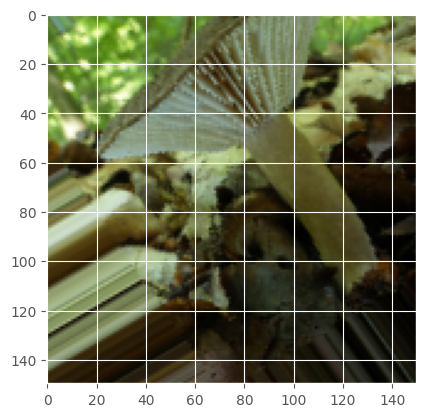

In [9]:
for batch in train_generator:
    print(batch[0].shape)
    plt.imshow(batch[0][13])
    break

In [10]:
callback_list = [
    EarlyStopping(monitor='accuracy', patience=1.),
    ModelCheckpoint(
        filepath='simpleCNN.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

## Simple CNN model
I assume this solution will be poor choice due to potential bias towards the majority class and inability to capture the nuances in the minority classes.

In [ ]:
#class_samples = [sum(y_train[:,i]) for i in range(9)]
#total_samples = sum(class_samples)
#class_weight = {i : total_samples / (9 * class_samples[i]) for i in range(10)}

In [11]:
from SimpleCNN import SimpleCNN

In [15]:
cnn = SimpleCNN(input_shape=(150,150,3), num_classes=9, load_weights='poor_mashrooms.h5')
cnn.load_generators(train_generator, val_generator)
cnn.load_callbacks(callback_list)
history = cnn.train(steps_per_epoch=235,
                         epochs=20,
                         validation_steps=50)

Epoch 1/20
235/235 [==============================] - 27s 112ms/step - loss: 1.3671 - accuracy: 0.5156 - precision: 0.7085 - recall: 0.2888 - auc: 0.8789 - prc: 0.5542 - val_loss: 1.4283 - val_accuracy: 0.4913 - val_precision: 0.6741 - val_recall: 0.3025 - val_auc: 0.8678 - val_prc: 0.5456
Epoch 2/20
235/235 [==============================] - 32s 136ms/step - loss: 1.3552 - accuracy: 0.5165 - precision: 0.7118 - recall: 0.2976 - auc: 0.8812 - prc: 0.5588 - val_loss: 1.3934 - val_accuracy: 0.4988 - val_precision: 0.6603 - val_recall: 0.3475 - val_auc: 0.8751 - val_prc: 0.5635
Epoch 3/20
235/235 [==============================] - 29s 123ms/step - loss: 1.3538 - accuracy: 0.5164 - precision: 0.7209 - recall: 0.3000 - auc: 0.8815 - prc: 0.5618 - val_loss: 1.3807 - val_accuracy: 0.5113 - val_precision: 0.6831 - val_recall: 0.3288 - val_auc: 0.8773 - val_prc: 0.5654


In [14]:
cnn.save('poor_mashrooms.h5')

In [15]:
history_dict = history.history

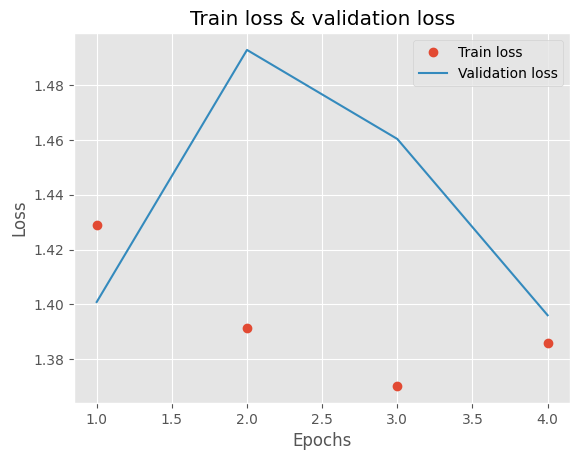

In [17]:
utils.loss_plot(history_dict, epochs=4)

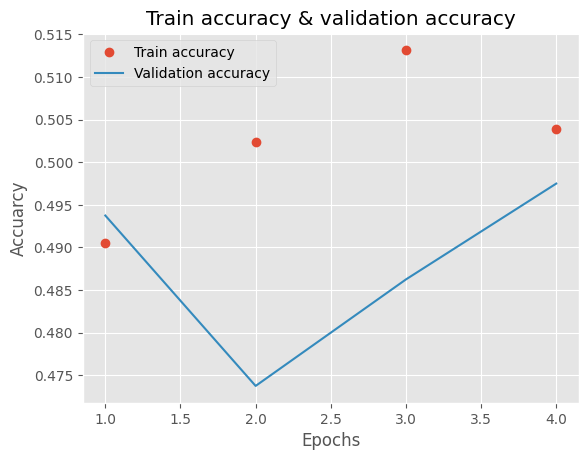

In [18]:
utils.acc_plot(history_dict, epochs=4)

Poor results, let's try something different

## VGG 

In [19]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
def extract_features(model_base, directory, sample_count, batch_size=20):
    conv_output_shape = model_base.layers[-1].output_shape[1:]
    shape = tuple([sample_count] + list(conv_output_shape))
    features = np.zeros(shape=shape)
    labels = np.zeros(shape=(sample_count,9))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical'
    )
    i = 0
    # Remember that generator returns data infinitely - we need break statement
    for inputs_batch, labels_batch in generator:
        feature_batch = model_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i+1) * batch_size] = feature_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
train_features, train_labels = extract_features(conv_base, train_dir, 4697)
val_features, val_labels = extract_features(conv_base, val_dir, 1000)
test_features, test_labels = extract_features(conv_base, test_dir, 1000)

Found 4697 images belonging to 9 classes.


2023-03-26 22:07:43.907660: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-26 22:07:43.907689: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-26 22:08:26.514703: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-26 22:08:26.514742: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

Found 1002 images belonging to 9 classes.
Found 1015 images belonging to 9 classes.


In [22]:
train_features.shape

(4697, 4, 4, 512)

In [23]:
train_features = np.reshape(train_features, (4697, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [24]:
dense_clf = Sequential([
    Dense(256, activation='relu', input_dim=4*4*512),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])
dense_clf.load_weights('dense_clf_mushrooms.h5')
dense_clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = dense_clf.fit(
    train_features,
    train_labels,
    epochs=20,
    callbacks=callback_list,
    batch_size=20,
    validation_data=(val_features, val_labels)
)

Epoch 1/20


2023-03-26 22:09:42.890177: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x556d332d6d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-26 22:09:42.890199: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-03-26 22:09:42.923404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-26 22:09:43.152941: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 [==============================] - 1s 2ms/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 7.9413 - val_accuracy: 0.5310
Epoch 2/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 7.8045 - val_accuracy: 0.5110
Epoch 3/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9874 - val_loss: 8.0109 - val_accuracy: 0.5200


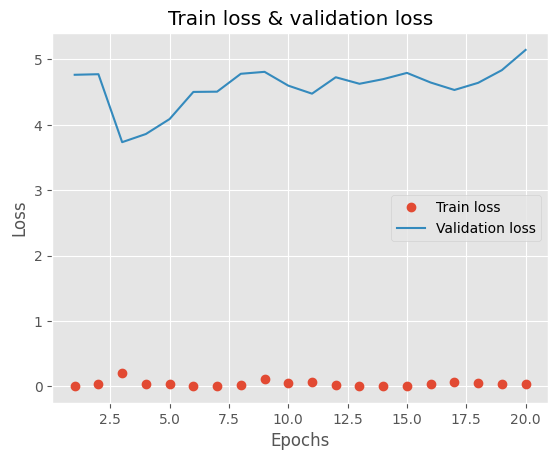

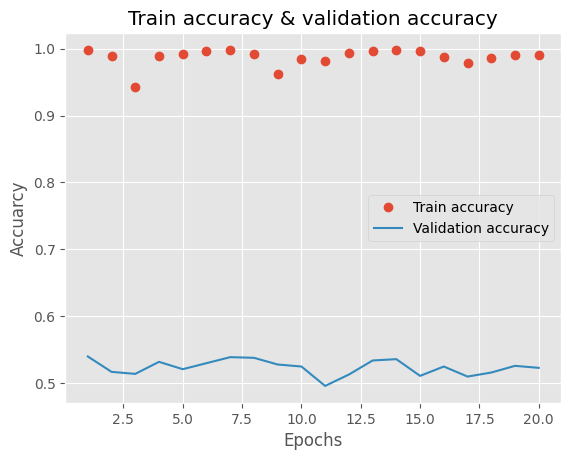

In [43]:
history_dict = history.history
utils.loss_plot(history_dict, epochs=20)
utils.acc_plot(history_dict, epochs=20)

Poor results on validation set

In [94]:
dense_clf.save('dense_clf_mushrooms.h5')

## VGG with conv layers train

In [87]:
full_model = Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')
])
full_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dense_42 (Dense)            (None, 256)               2097408   
                                                                 
 dense_43 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 16,814,409
Trainable params: 2,099,721
Non-trainable params: 14,714,688
_________________________________________________________________


In [88]:
conv_base.trainable = False

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

Found 4697 images belonging to 9 classes.
Found 1002 images belonging to 9 classes.


In [ ]:
full_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
history = full_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=val_generator,
    validation_steps=50
)

Epoch 1/20
100/100 [==============================] - 20s 196ms/step - loss: 1.9051 - accuracy: 0.3110 - val_loss: 1.7692 - val_accuracy: 0.3390
Epoch 2/20
100/100 [==============================] - 20s 196ms/step - loss: 1.6944 - accuracy: 0.3800 - val_loss: 1.6286 - val_accuracy: 0.4220
Epoch 3/20
100/100 [==============================] - 20s 202ms/step - loss: 1.6269 - accuracy: 0.4080 - val_loss: 1.5177 - val_accuracy: 0.4830
Epoch 4/20
100/100 [==============================] - 20s 200ms/step - loss: 1.6034 - accuracy: 0.4196 - val_loss: 1.4944 - val_accuracy: 0.4710
Epoch 5/20
100/100 [==============================] - 20s 203ms/step - loss: 1.5748 - accuracy: 0.4430 - val_loss: 1.5011 - val_accuracy: 0.4670
Epoch 6/20
100/100 [==============================] - 20s 203ms/step - loss: 1.4988 - accuracy: 0.4690 - val_loss: 1.4649 - val_accuracy: 0.4800
Epoch 7/20
100/100 [==============================] - 20s 205ms/step - loss: 1.5167 - accuracy: 0.4612 - val_loss: 1.5644 - val_ac

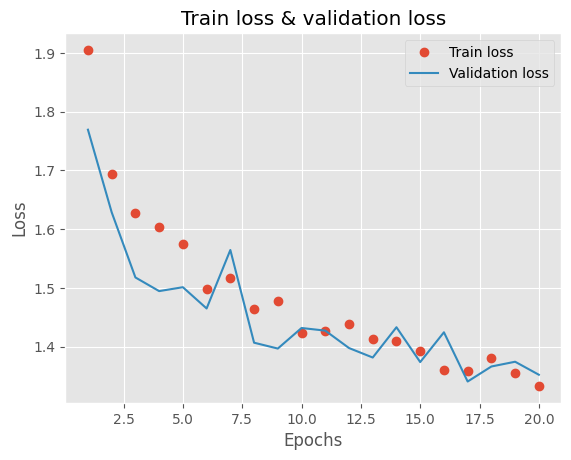

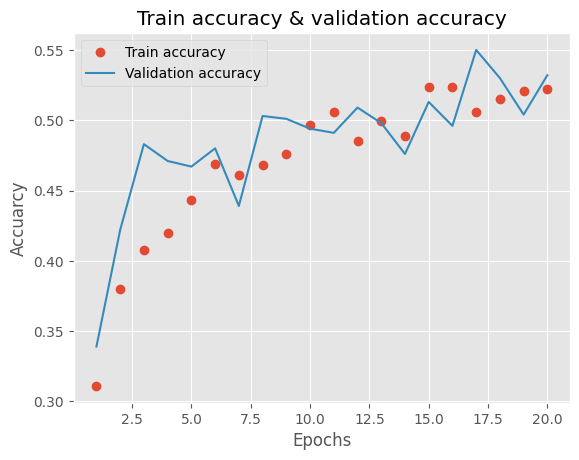

In [92]:
history_dict = history.history
utils.loss_plot(history_dict, epochs=20)
utils.acc_plot(history_dict, epochs=20)

In [93]:
full_model_model.save('vgg_mushrooms.h5')

## MobileNet

In [26]:
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(150,150,3))
# mobilenet_base.summary()

In [42]:
datagen = ImageDataGenerator(rescale=1./255)
train_features, train_labels = extract_features(mobilenet_base, train_dir, 4697)
val_features, val_labels = extract_features(mobilenet_base, val_dir, 1000)
test_features, test_labels = extract_features(mobilenet_base, test_dir, 1000)

Found 4697 images belonging to 9 classes.
1/1 [==============================] - 1s 568ms/step
Found 1002 images belonging to 9 classes.
1/1 [==============================] - 0s 17ms/step
Found 1015 images belonging to 9 classes.
1/1 [==============================] - 0s 16ms/step


In [66]:
lambda_coef = 0.001

model = Sequential([
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(lambda_coef)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lambda_coef)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
history = model.fit(
    train_features, 
    train_labels, 
    epochs=30, 
    batch_size=20, 
    validation_data=(val_features, val_labels)
)

Epoch 1/30
  4/235 [..............................] - ETA: 4s - loss: 8.9346 - accuracy: 0.1750 

/home/kamil/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


235/235 [==============================] - 5s 21ms/step - loss: 2.8932 - accuracy: 0.3515 - val_loss: 2.0951 - val_accuracy: 0.4630
Epoch 2/30
235/235 [==============================] - 5s 22ms/step - loss: 2.1647 - accuracy: 0.4343 - val_loss: 1.9153 - val_accuracy: 0.4710
Epoch 3/30
235/235 [==============================] - 5s 21ms/step - loss: 1.9282 - accuracy: 0.4937 - val_loss: 1.7950 - val_accuracy: 0.5560
Epoch 4/30
235/235 [==============================] - 5s 19ms/step - loss: 1.7915 - accuracy: 0.5267 - val_loss: 1.7305 - val_accuracy: 0.5320
Epoch 5/30
235/235 [==============================] - 5s 20ms/step - loss: 1.6016 - accuracy: 0.5712 - val_loss: 1.6811 - val_accuracy: 0.5730
Epoch 6/30
235/235 [==============================] - 5s 20ms/step - loss: 1.5388 - accuracy: 0.5936 - val_loss: 1.6540 - val_accuracy: 0.5870
Epoch 7/30
235/235 [==============================] - 5s 20ms/step - loss: 1.3403 - accuracy: 0.6674 - val_loss: 1.9181 - val_accuracy: 0.5950
Epoch 8/30

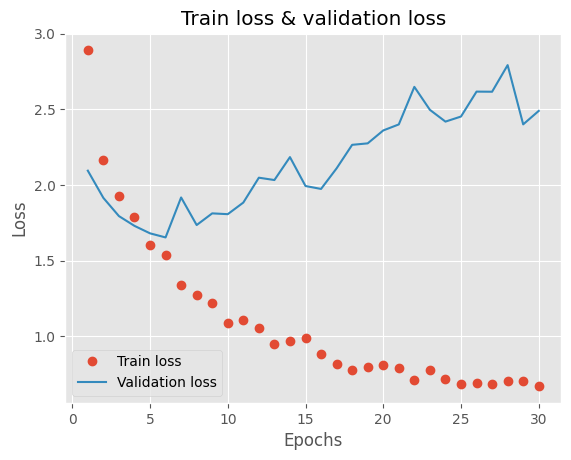

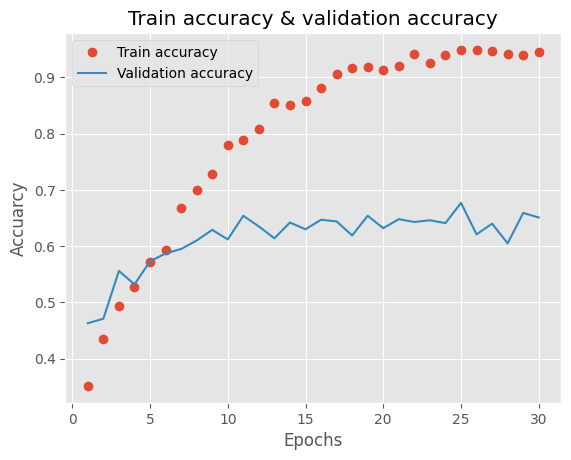

In [68]:
history_dict = history.history
utils.loss_plot(history_dict, epochs=30)
utils.acc_plot(history_dict, epochs=30)

## MobileNet with data augmentation

In [69]:
model = Sequential([
    mobilenet_base,
    Flatten(),
    Dense(16, activation='relu'),
    Dense(9, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
mobilenet_base.trainable = False

In [71]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 16384)             0         
                                                                 
 dense_17 (Dense)            (None, 16)                262160    
                                                                 
 dense_18 (Dense)            (None, 9)                 153       
                                                                 
Total params: 3,491,177
Trainable params: 262,313
Non-trainable params: 3,228,864
_________________________________________________________________


In [9]:
train_datagen = ImageDataGenerator( # Data augmentation
    rescale=1./255,
    rotation_range=40,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

Found 4697 images belonging to 9 classes.
Found 1002 images belonging to 9 classes.


In [2]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30, 
    validation_steps=50,
    validation_data=val_generator
)

NameError: name 'model' is not defined

## Resnet50

In [9]:
resnet50_base = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(150,150,3))

In [10]:
resnet50_base.trainable = False

In [11]:
model = Sequential([
    resnet50_base,
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(9, activation='softmax')
])

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=16
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=16
)

Found 4697 images belonging to 9 classes.
Found 1002 images belonging to 9 classes.


In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30, 
    validation_steps=50,
    validation_data=val_generator
)

Epoch 1/30
  4/100 [>.............................] - ETA: 18s - loss: 2.9393 - acc: 0.0938

2023-03-26 21:41:31.364421: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_49 in the registry.
Traceback (most recent call last):

  File "/home/kamil/anaconda3/envs/data_science/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_49 in the registry.




InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: Could not find callback with key=pyfunc_49 in the registry.
Traceback (most recent call last):

  File "/home/kamil/anaconda3/envs/data_science/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_49 in the registry.


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]